### Company XYZ is a food delivery company. Like pretty much any other site, in order to get customers, they have been relying significantly on online ads, such as those you see on Google or Facebook.

### At the moment, they are running 40 different ad campaigns and want you to help them understand their performance. Specifically, you are asked to:

#### (1) If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

#### (2) For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

#### (3) Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

### Read in the data set

In [2]:
ads = pd.read_csv("../Datasets/ad_table.csv")

### Look into dataset

In [3]:
print(ads.shape)
print(ads.head)
print(ads.info)
print(list(ads.columns))

(2115, 7)
<bound method NDFrame.head of             date  shown  clicked  converted  avg_cost_per_click  total_revenue           ad
0     2015-10-01  65877     2339         43                0.90         641.62   ad_group_1
1     2015-10-02  65100     2498         38                0.94         756.37   ad_group_1
2     2015-10-03  70658     2313         49                0.86         970.90   ad_group_1
3     2015-10-04  69809     2833         51                1.01         907.39   ad_group_1
4     2015-10-05  68186     2696         41                1.00         879.45   ad_group_1
...          ...    ...      ...        ...                 ...            ...          ...
2110  2015-11-18  78111     1326         37                1.01         553.36  ad_group_40
2111  2015-11-19  79857     1413         34                1.00         840.72  ad_group_40
2112  2015-11-20  75695     1332         35                1.09         468.95  ad_group_40
2113  2015-11-21  73761     1336        

In [4]:
ads["date"] = pd.to_datetime(ads["date"])
print(ads.describe())
print(ads.groupby(["ad"]).size())
print(ads.groupby(["date"]).size())

               shown       clicked    converted  avg_cost_per_click  total_revenue
count    2115.000000   2115.000000  2115.000000         2115.000000    2115.000000
mean    68299.844444   3056.077069   126.453901            1.373749    1966.517589
std     48884.821409   3783.579969   233.420826            0.754331    3942.018757
min         0.000000      0.000000     0.000000            0.000000    -200.150000
25%     28030.500000    744.000000    18.000000            0.760000     235.470000
50%     54029.000000   1392.000000    41.000000            1.400000     553.300000
75%     97314.500000   3366.500000   103.000000            1.920000    1611.495000
max    192507.000000  20848.000000  1578.000000            4.190000   39623.710000
ad
ad_group_1     53
ad_group_10    52
ad_group_11    53
ad_group_12    53
ad_group_13    53
ad_group_14    52
ad_group_15    53
ad_group_16    53
ad_group_17    53
ad_group_18    52
ad_group_19    53
ad_group_2     53
ad_group_20    52
ad_group_21    5

### Data processing

#### Create variables CTR, conversion rate, cost, revenue, and return

In [5]:
ads["cost"] = ads["avg_cost_per_click"] * ads["clicked"]
ads["cost"].describe()

count     2115.000000
mean      5668.448057
std       8828.492245
min          0.000000
25%        480.885000
50%       1993.410000
75%       6580.040000
max      66922.080000
Name: cost, dtype: float64

In [6]:
ads["CTR"] = ads["clicked"] / ads["shown"]
ads["CTR"].describe()

count    2102.000000
mean        0.046534
std         0.032601
min         0.000000
25%         0.013885
50%         0.041158
75%         0.075079
max         0.123993
Name: CTR, dtype: float64

In [7]:
ads["convertion"] = ads["converted"] / ads["shown"]
ads["convertion"].describe()

count    2102.000000
mean        0.001966
std         0.002200
min         0.000000
25%         0.000350
50%         0.000987
75%         0.002780
max         0.009533
Name: convertion, dtype: float64

In [8]:
ads["return"] = ads["total_revenue"] / (ads["clicked"] * ads["avg_cost_per_click"])
ads["return"].describe()

count    2095.000000
mean        0.758502
std         1.550388
min        -0.119340
25%         0.128964
50%         0.355041
75%         0.750604
max        19.303349
Name: return, dtype: float64

### Visualization

In [9]:
ads

,date,shown,clicked,converted,avg_cost_per_click,...,ad,cost,CTR,convertion,return
0,2015-10-01,65877,2339,43,0.90,...,ad_group_1,2105.10,0.035506,0.000653,0.304793
1,2015-10-02,65100,2498,38,0.94,...,ad_group_1,2348.12,0.038372,0.000584,0.322117
2,2015-10-03,70658,2313,49,0.86,...,ad_group_1,1989.18,0.032735,0.000693,0.488091
3,2015-10-04,69809,2833,51,1.01,...,ad_group_1,2861.33,0.040582,0.000731,0.317122
4,2015-10-05,68186,2696,41,1.00,...,ad_group_1,2696.00,0.039539,0.000601,0.326205
...,...,...,...,...,...,...,...,...,...,...,...
2110,2015-11-18,78111,1326,37,1.01,...,ad_group_40,1339.26,0.016976,0.000474,0.413183
2111,2015-11-19,79857,1413,34,1.00,...,ad_group_40,1413.00,0.017694,0.000426,0.594989
2112,2015-11-20,75695,1332,35,1.09,...,ad_group_40,1451.88,0.017597,0.000462,0.322995
2113,2015-11-21,73761,1336,36,1.11,...,ad_group_40,1482.96,0.018113,0.000488,0.294701


In [10]:
ads["ad_group"] = pd.DataFrame(ads["ad"].str.split("_", 3).tolist())[2].astype(int)
ads = ads.sort_values(by = ["ad_group", "date"])

Text(0, 0.5, 'Mean Cost')

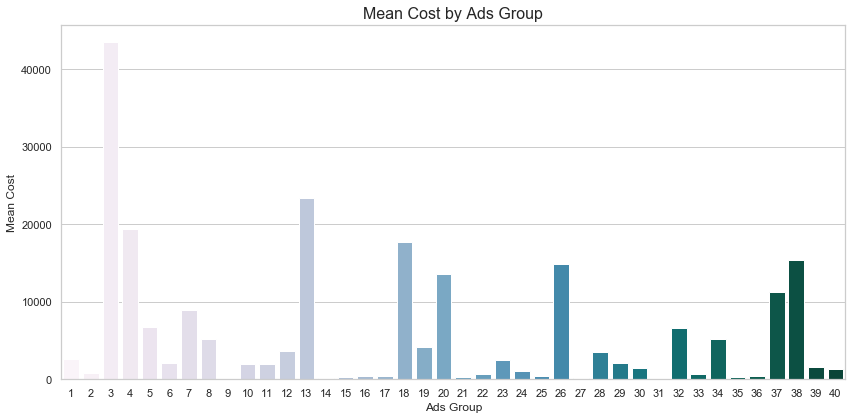

In [11]:
grp_cost = ads[["cost", "ad_group"]].groupby("ad_group").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "ad_group", y = "cost", data = grp_cost, palette = "PuBuGn")
plt.title("Mean Cost by Ads Group", fontsize = 16)
plt.xlabel("Ads Group", fontsize = 12)
plt.ylabel("Mean Cost", fontsize = 12)

Text(0, 0.5, 'Mean CTR')

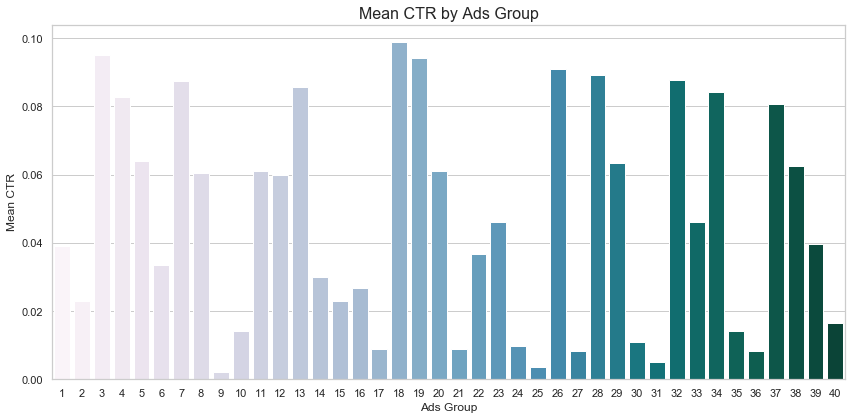

In [12]:
grp_CTR = ads[["CTR", "ad_group"]].groupby("ad_group").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "ad_group", y = "CTR", data = grp_CTR, palette = "PuBuGn")
plt.title("Mean CTR by Ads Group", fontsize = 16)
plt.xlabel("Ads Group", fontsize = 12)
plt.ylabel("Mean CTR", fontsize = 12)

Text(0, 0.5, 'Mean Convertion Rate')

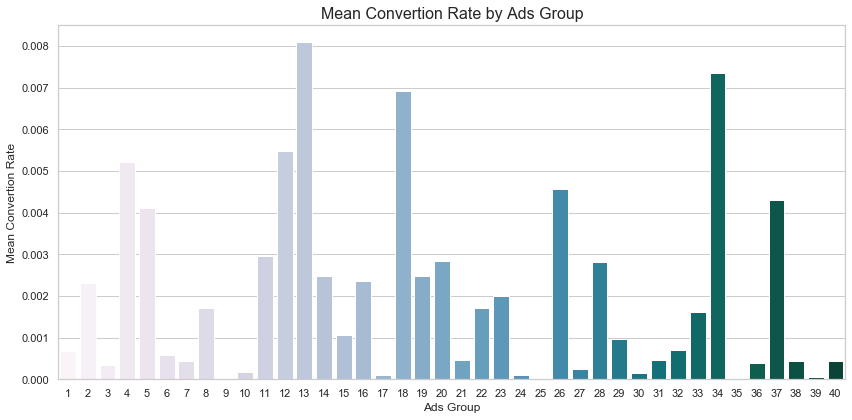

In [13]:
grp_convertion = ads[["convertion", "ad_group"]].groupby("ad_group").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "ad_group", y = "convertion", data = grp_convertion, palette = "PuBuGn")
plt.title("Mean Convertion Rate by Ads Group", fontsize = 16)
plt.xlabel("Ads Group", fontsize = 12)
plt.ylabel("Mean Convertion Rate", fontsize = 12)

Text(0, 0.5, 'Mean Return')

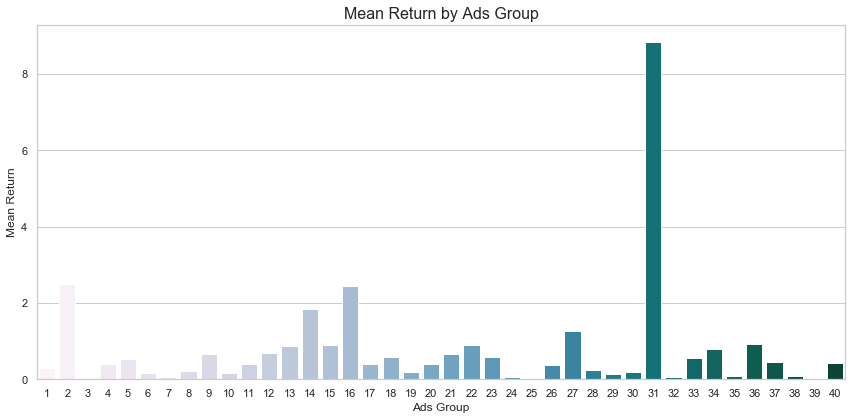

In [14]:
grp_return = ads[["return", "ad_group"]].groupby("ad_group").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "ad_group", y = "return", data = grp_return, palette = "PuBuGn")
plt.title("Mean Return by Ads Group", fontsize = 16)
plt.xlabel("Ads Group", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)

#### (1) If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

See my R solution.

#### (2) For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Shown')

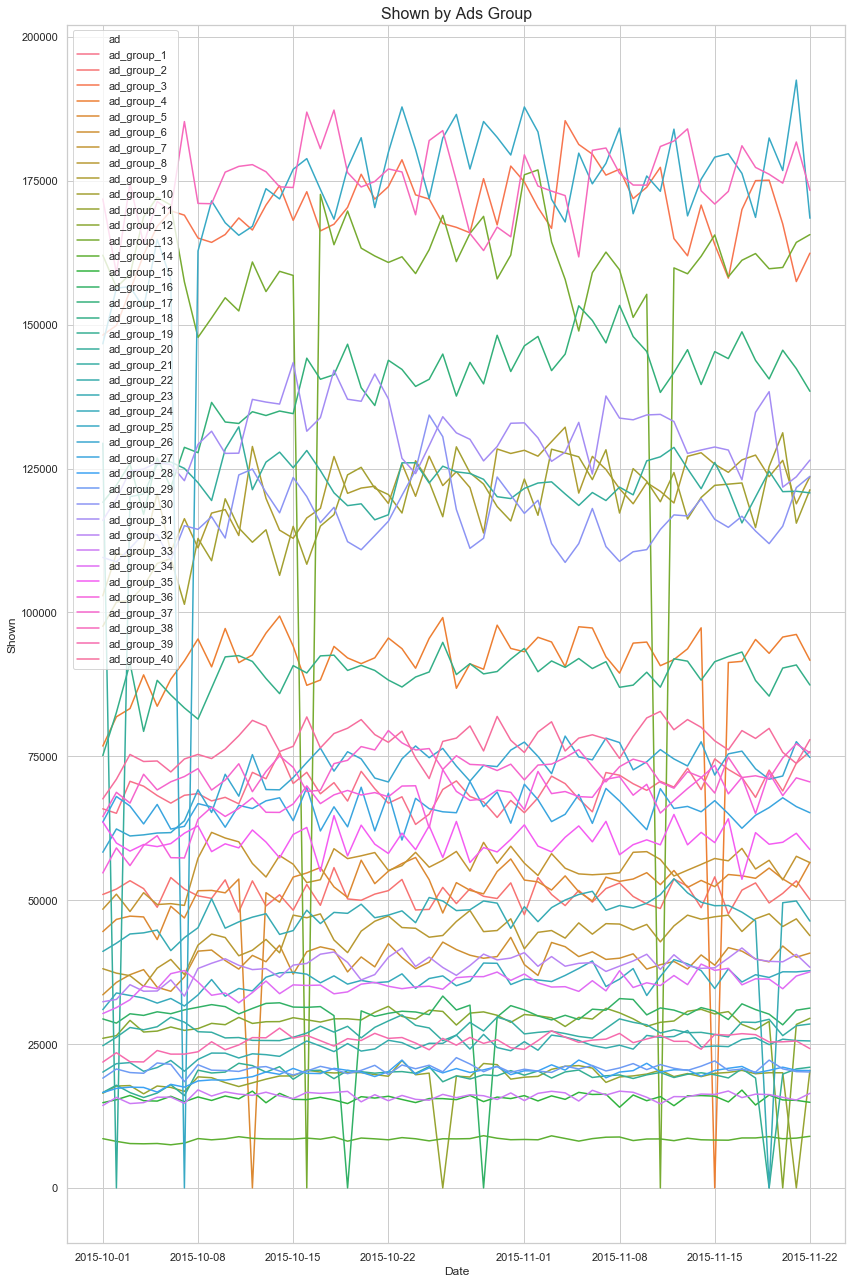

In [15]:
plt.figure(figsize = [12, 18])
sns.lineplot(x = "date", y = "shown", hue = "ad", data = ads)
plt.title("Shown by Ads Group", fontsize = 16)
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Shown", fontsize = 12)

In [16]:
delta = pd.date_range("2015-11-22", "2015-12-15").shape[0] - 1

In [17]:
def ts_AR(dat):
    model = AR(dat["shown"])
    model_fit = model.fit()
    Dec15 = model_fit.predict(len(dat), len(dat) + delta - 1).tail(1).values
    return Dec15

AR_by_ad_group = ads.groupby("ad_group").apply(ts_AR)
AR_by_ad_group.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:573: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:573: ValueWarning: No supported index is available. 

ad_group
1     [69117.64721442715]
2     [50885.57521510721]
3    [171827.73537478273]
4      [97868.0343394161]
5     [52904.66564025689]
dtype: object

#### (3) Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

In [18]:
baseline = ads[["ad_group", "date"]].groupby("ad_group").min().reset_index().rename(columns = {"date": "baseline"})
baseline
ads = ads.merge(baseline, on = "ad_group", how = "left").sort_values(by = ["ad_group", "date"])
ads.head()
ads["date_delta"] = (ads["date"] - ads["baseline"]).astype("timedelta64[D]")
ads["const"] = 1.0

In [19]:
def ols_res(dat, xcols, ycol):
    lin_reg = sm.OLS(dat[ycol], dat[xcols]).fit()
    intercept = lin_reg.params.values[0]
    slope = lin_reg.params.values[1]
    pvalue = lin_reg.pvalues.values[1]
    return {"intercept": intercept, "slope": slope, "pvalue": pvalue}

avg_cost_per_click_by_ads = ads.groupby("ad_group").apply(ols_res, xcols = ["const", "date_delta"], ycol = "avg_cost_per_click")
avg_cost_per_click_by_ads.head()

ad_group
1    {'intercept': 0.9472327044025164, 'slope': 0.0...
2    {'intercept': 0.6382809224318661, 'slope': -6....
3    {'intercept': 2.618700209643608, 'slope': 0.00...
4    {'intercept': 2.6508385744234815, 'slope': -0....
5    {'intercept': 1.9512788259958083, 'slope': 0.0...
dtype: object

In [20]:
reg_rows = []
for i in range(len(avg_cost_per_click_by_ads)):
    reg_rows.append(avg_cost_per_click_by_ads.iloc[i])

reg_dat = pd.DataFrame.from_dict(reg_rows, orient = "columns")
reg_dat

,intercept,slope,pvalue
0,0.947233,0.000926,0.145429
1,0.638281,-0.000006,0.991095
2,2.618700,0.002445,0.255564
3,2.650839,-0.007732,0.116502
4,1.951279,0.001453,0.609696
5,1.630168,-0.001734,0.077129
6,1.879623,-0.002569,0.120068
7,2.031048,-0.002689,0.026231
8,0.091488,0.000044,0.434626
9,1.170325,-0.000161,0.861238


In [21]:
reg_dat["group"] = reg_dat["pvalue"].apply(lambda x: "flat" if x > 0.05 else "other")
reg_dat.loc[(reg_dat["slope"] > 0) & (reg_dat["group"] == "other"), "group"] = "going up"
reg_dat.loc[(reg_dat["slope"] < 0) & (reg_dat["group"] == "other"), "group"] = "going down"
reg_dat

,intercept,slope,pvalue,group
0,0.947233,0.000926,0.145429,flat
1,0.638281,-0.000006,0.991095,flat
2,2.618700,0.002445,0.255564,flat
3,2.650839,-0.007732,0.116502,flat
4,1.951279,0.001453,0.609696,flat
5,1.630168,-0.001734,0.077129,flat
6,1.879623,-0.002569,0.120068,flat
7,2.031048,-0.002689,0.026231,going down
8,0.091488,0.000044,0.434626,flat
9,1.170325,-0.000161,0.861238,flat
